##цель: построить понятный и воспроизводимый инструмент анализа тональности отзывов.


In [ ]:
import random
import string
from typing import List, Tuple
import nltk
from nltk.corpus import movie_reviews, stopwords

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

import re
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer


from sklearn.pipeline import FeatureUnion


создается шаблон очистки данных.
* Загружает датасет movie_reviews, чистит текст (перевод в нижний регистр, удаление пунктуационных знаков и удаление стоп-слов, которые как правило незначительны но перегружают модель).
* Возвращает тексты, метки и фиксированный train/test сплит.

In [ ]:
def ensure_nltk():
    nltk.download("movie_reviews", quiet=True)
    nltk.download("stopwords", quiet=True)

def load_raw_movie_reviews() -> List[Tuple[List[str], str]]:
    documents = [
        (list(movie_reviews.words(fileid)), category)
        for category in movie_reviews.categories()
        for fileid in movie_reviews.fileids(category)
    ]
    random.shuffle(documents)
    return documents

def build_texts_and_labels(documents: List[Tuple[List[str], str]]):
    texts = [" ".join(words) for words, _ in documents]
    labels = [label for _, label in documents]
    return texts, labels

def get_cleaner():
    stop_words = set(stopwords.words("english"))
    def clean_text(text: str) -> str:
        text = text.lower()
        text = "".join(ch for ch in text if ch not in string.punctuation)
        words = [w for w in text.split() if w not in stop_words]
        return " ".join(words)
    return clean_text

def make_splits(test_size = 0.2, random_state = 42):
    ensure_nltk()
    docs = load_raw_movie_reviews()
    texts, labels = build_texts_and_labels(docs)
    clean = get_cleaner()
    texts_clean = [clean(t) for t in texts]
    X_train, X_test, y_train, y_test = train_test_split(
        texts_clean, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    return X_train, X_test, y_train, y_test, clean

###**Модель 1. TF‑IDF + MultinomialNB**

Содержит:
* TF‑IDF с ограничением фич 3000 + MultinomialNB.
* Метрики: accuracy, F1, отчёт, confusion matrix.
* Простой интерактив для ручной проверки.

Accuracy: 0.83
F1 (pos): 0.8238
              precision    recall  f1-score   support

         neg       0.81      0.86      0.84       200
         pos       0.85      0.80      0.82       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



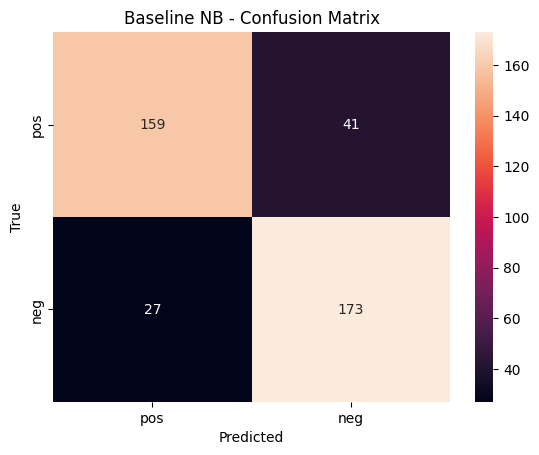

Введите отзыв (или 'exit'): This movie was absolutely fantastic! I loved it.
Positive
Введите отзыв (или 'exit'): Fantastic cast!
Positive
Введите отзыв (или 'exit'): This was a raunch. Tasteless waste of celluloid. How did such famous and talented actors agree to this?
Negative
Введите отзыв (или 'exit'): That's a work of art!
Positive
Введите отзыв (или 'exit'): YAY!!!!
Negative
Введите отзыв (или 'exit'): Not bad... definitely interesting cinematic experience
Negative
Введите отзыв (или 'exit'): Not bad and not good
Negative
Введите отзыв (или 'exit'): I don't know how to feel. but ralph fiennes is great as always
Positive
Введите отзыв (или 'exit'): This movie is ass.
Negative
Введите отзыв (или 'exit'): Terrible movie. Waste of time.
Negative
Введите отзыв (или 'exit'): Well... ok, it was pretty interesting. Maybe I need to rewatch, idk
Negative
Введите отзыв (или 'exit'): It was good
Negative
Введите отзыв (или 'exit'): i'm never getting this festival stuff, I'll go rewatch Big D

In [ ]:
def run_baseline():
    X_train, X_test, y_train, y_test, clean = make_splits()

    vectorizer = TfidfVectorizer(max_features=3000)
    Xtr = vectorizer.fit_transform(X_train)
    Xte = vectorizer.transform(X_test)

    model = MultinomialNB()
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label="pos")
    print("Accuracy:", round(acc, 4))
    print("F1 (pos):", round(f1, 4))
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=["pos", "neg"])
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["pos", "neg"], yticklabels=["pos", "neg"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Baseline NB - Confusion Matrix")
    plt.show()

    def predict_sentiment(text: str) -> str:
        text_c = clean(text)
        vec = vectorizer.transform([text_c])
        pred = model.predict(vec)[0]
        return "Positive" if pred == "pos" else "Negative"

    return predict_sentiment


predictor = run_baseline()
while True:
    t = input("Введите отзыв (или 'exit'): ")
    if t.lower().strip() == "exit":
        break
    print(predictor(t))

**Интерпретация метрик**
* Accuracy - доля верных предсказаний. Удобна при сбалансированных классах. Подходит к данной задаче (у нас 1:1), не отображает, какие ошибки дороже.
* Precision - среди предсказанных "pos"/"neg" — какая доля действительно "pos"/"neg". Доля высока —> мало ложных "pos"/"neg".
* Recall - среди реальных "pos"/"neg" — какую долю реальных "pos"/"neg" определили. Высок —> мало пропущенных "pos"/"neg".
* F1 (для pos) - гармоническое среднее precision и recall. Если важно одновременно минимизировать ложные pos и не пропускать pos существующие.
* Confusion matrix: разложение на TP/FP/FN/TN — где именно промахи.

**Анализ результатов**

Ошибки распределены похоже, небольшой перевес в пользу лучшего распознавания «neg». Это типично для MultinomialNB: он прост, чувствителен к предположению условной независимости слов и к выбору препроцессинга. Это в нек-рой степени допустимо, т.к. в задаче вывления тональности часто важнее найти негативный отзыв и оперативно на него среагировать.

На результате видно проблему: удаление стоп‑слов NLTK выкидывает не только незначительное - артикли, глаголы связки и т.п., но и частицы типа not, no, глаголы вроде don’t, что разрушает отрицания (not bad = bad). То есть для задачи тональности лучше не удалять стоп‑слова, а компенсировать их биграммами или специально сохранять отрицания.

также некоторые слова - вроде междометий (Wow!, Yay!) модель склонна считывать как негативную реакцию за непониманием что это может значить.

слова нейтрально-положительного оттенка вроде cool и nice часто считываются моделью как негативная реакция

Что исправить
1. Лучше обучить модель на датасете большего размера. 2000 отзывов явно недостаточно.
2. Не исключать отрицания (not/no/never) и развернуть сокращения (don’t → do not).
3. N-граммы: лучше брать и униграммы и биграммы, чтобы ловить «not good», «no wonder» и т.п.
4. Буквенные n-граммы дополнительно к словным — помогают со сленгом/опечатками («awesooome», «meh…»).
5. Если ситуация не исправится стоит взять более сильный классификатор.

#### **Модификация 1. Новый датасет, исключение важных для контекста слов из стоп-листа, разворачивание отрицаний, лемматизация, фильтрация части слов во избежание переобучения**

In [ ]:
# Загружаем необходимые ресурсы NLTK (стоп-слова, леммы)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True) # словари для wordnet


# Загрузка IMDB (50k)
dataset = load_dataset("imdb")  # загрузит train/test по умолчанию
# dataset["train"]["text"] — список текстов, dataset["train"]["label"] — 0/1. 0=neg, 1=pos
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts  = dataset["test"]["text"]
test_labels = dataset["test"]["label"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Препроцессинг текста
# - Нормализация сокращений (don't -> not)
# - Простая токенизация
# - Лемматизация
# - Удаление стоп-слов, но СОХРАНЯЕМ отрицания и контрастные союзы (but, however)
# - Склейка "not_X" для немедленных отрицаний (не заменяет полноценный парсинг!)

# Создаём набор стоп-слов NLTK, но исключаем из него важные слова:
_base_stop = set(stopwords.words("english"))

# Сохраняем явные отрицания
_negations = {
    "no","not","nor","n't","dont","don't","didnt","didn't","cant","can't",
    "couldnt","couldn't","wont","won't","wasnt","wasn't","isnt","isn't",
    "shouldnt","shouldn't","wouldnt","wouldn't","aint","ain't"
}

# Сохраняем также слова, которые дают контраст/поворот смысла: but, however и тп. Если мы удалим 'but', то потеряем сильный сигнал "X, but Y" — Y часто важнее.
_contrasts = {"but","however","although","though","yet","still","instead","rather"}

# Финальный набор стоп-слов: базовый минус (negations ∪ contrasts)
STOP_WORDS = _base_stop - (_negations | _contrasts)

# Лемматизатор
LEMM = WordNetLemmatizer()

# Простейшая нормализация распространённых сокращений: n['’]t -> not, won't -> will not и т.п.
_CONTRACTIONS = [
    (r"n['’]t\b", " not"),
    (r"can['’]t\b", "can not"),
    (r"won['’]t\b", "will not"),
    (r"didn['’]t\b", "did not"),
    (r"don['’]t\b", "do not"),
    (r"ain['’]t\b", "is not"),
    (r"aren['’]t\b", "are not"),
    (r"isn['’]t\b", "is not"),
]

def normalize_contractions(text: str) -> str:
    """Заменяет часть сокращений на развернутую форму (don't -> do not),
       чтобы 'not' получилось в тексте для последующей обработки."""
    for pat, repl in _CONTRACTIONS:
        text = re.sub(pat, repl, text, flags=re.IGNORECASE)
    return text

# Регулярка для токенов: буквы и апостроф (после нормализации апострофов мало)
_word_re = re.compile(r"[a-zA-Z']+")

def clean_text(text: str) -> str:
    # нижний регистр
    text = text.lower()
    # нормализация сокращений
    text = normalize_contractions(text)

    # Токенизация
    tokens = _word_re.findall(text)

    # Убираем чистые стоп-слова и лемматизируем
    tokens = [LEMM.lemmatize(w) for w in tokens if w not in STOP_WORDS]

    # Дополнительная эвристика: если встречаем "not W", объединяем в "not_w" — усиливаем сигнал
    fused = []
    i = 0
    while i < len(tokens):
        if tokens[i] == "not" and (i + 1) < len(tokens):
            fused.append(f"not_{tokens[i+1]}")
            i += 2
        else:
            fused.append(tokens[i])
            i += 1

    return " ".join(fused) # Возвращает строку: токены, разделённые пробелами.

# Применяем очистку к train/test
# Если хочется, можно применить map/ThreadPool для ускорения, но сейчас простой вариант.
print("Cleaning train (first 2 samples preview):")
print("Before:", train_texts[0][:200])
print("After:", clean_text(train_texts[0])[:200])

train_texts_clean = [clean_text(t) for t in train_texts]
test_texts_clean  = [clean_text(t) for t in test_texts]


Cleaning train (first 2 samples preview):
Before: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev
After: rented curious yellow video store controversy surrounded first released also heard first seized u custom ever tried enter country therefore fan film considered controversial really see br br plot cent


Accuracy: 0.8398
Macro-F1: 0.8395

              precision    recall  f1-score   support

         neg       0.81      0.88      0.85     12500
         pos       0.87      0.80      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

TN = 11031, TP = 9963, FN = 2537, FP = 1469


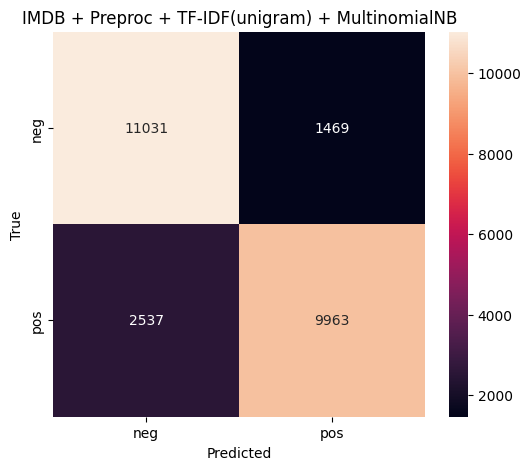


Interactive test. Type 'exit' to stop.
Введите отзыв (или 'exit'): This movie was absolutely fantastic! I loved it.
RAW TEXT:
This movie was absolutely fantastic! I loved it.

CLEANED TOKENS:
movie absolutely fantastic loved

PREDICTION: Positive
PROBS: Negative=0.189, Positive=0.811

TOP FEATURES (by TF-IDF in this text):
 - fantastic (tfidf=0.6200)
 - loved (tfidf=0.5442)
 - absolutely (tfidf=0.5305)
 - movie (tfidf=0.1949)

--------------------------------------------------

Введите отзыв (или 'exit'): Fantastic cast!
RAW TEXT:
Fantastic cast!

CLEANED TOKENS:
fantastic cast

PREDICTION: Positive
PROBS: Negative=0.194, Positive=0.806

TOP FEATURES (by TF-IDF in this text):
 - fantastic (tfidf=0.8323)
 - cast (tfidf=0.5543)

--------------------------------------------------

Введите отзыв (или 'exit'): This was a raunch. Tasteless waste of celluloid. How did such famous and talented actors agree to this?
RAW TEXT:
This was a raunch. Tasteless waste of celluloid. How did such famous

In [ ]:

# Создаём TF-IDF и обучаем MultinomialNB. Параметры: max_features (максимальное количество слов - самые частые слова), min_df (минимальная частота встречаемости для попадания в словарь) — чтобы ограничить шум редких токенов
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,1), min_df=2)
Xtr = vectorizer.fit_transform(train_texts_clean)  # обучаем словарь
Xte = vectorizer.transform(test_texts_clean)        # применяем трансформацию к test

nb = MultinomialNB()
nb.fit(Xtr, train_labels)

# Оценка качества
y_pred = nb.predict(Xte)
acc = accuracy_score(test_labels, y_pred)
macro_f1 = f1_score(test_labels, y_pred, average="macro")
print("Accuracy:", round(acc, 4))
print("Macro-F1:", round(macro_f1, 4))
print()
print(classification_report(test_labels, y_pred, target_names=["neg","pos"]))

# confusion matrix: формат [[TN, FP],[FN, TP]]
cm = confusion_matrix(test_labels, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"TN = {tn}, TP = {tp}, FN = {fn}, FP = {fp}")

# Визуализация матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("IMDB + Preproc + TF-IDF(unigram) + MultinomialNB")
plt.show()


# функция для проверки и отладки. Показывает, как текст чистится, какие признаки появляются в TF-IDF, а также предсказание и вероятности (predict_proba).

label_map = {0: "Negative", 1: "Positive"}

def predict_and_explain(raw_text: str, top_feats: int = 10):
    cleaned = clean_text(raw_text)
    vec = vectorizer.transform([cleaned])
    pred = nb.predict(vec)[0]
    if hasattr(nb, "predict_proba"):
        probs = nb.predict_proba(vec)[0]
    else:
        probs = None

    print("RAW TEXT:")
    print(raw_text)
    print("\nCLEANED TOKENS:")
    print(cleaned)
    print("\nPREDICTION:", label_map[pred])

    if probs is not None:
        print("PROBS: Negative={:.3f}, Positive={:.3f}".format(probs[0], probs[1]))

    # top features (токены) с наибольшим TF-IDF для конкретного примера
    # превращаем в плотный массив, получаем индексы ненулевых колонок
    nz = vec.nonzero()[1]
    feat_names = np.array(vectorizer.get_feature_names_out())
    if len(nz) > 0:
        # сортировка по значению TF-IDF в векторе
        values = vec.toarray()[0, nz]
        order = np.argsort(values)[::-1][:top_feats]
        top_idx = nz[order]
        print("\nTOP FEATURES (by TF-IDF in this text):")
        for i in top_idx:
            print(f" - {feat_names[i]} (tfidf={vec.toarray()[0,i]:.4f})")
    else:
        print("\nNo known features found in this text (rare tokens / all removed by stopwords).")

# цикл для ввода из консоли
print("\nInteractive test. Type 'exit' to stop.")
while True:
    s = input("Введите отзыв (или 'exit'): ")
    if s is None:
        break
    if s.strip().lower() == "exit":
        break
    predict_and_explain(s)
    print("\n" + "-"*50 + "\n")


**Анализ результатов**

Модель теперь лучше видит отрицания, лучше воспринимает некоторые слова вроде cool и nice и чаще верно угадывает тон на примерах с клавиатуры - это видно на тестах, - однако остаются надочеты. Метрики остаются примерно теми же, что и в изначальной модели. Ошибки так же смещены: модель чаще считывает позитивные отзывы как негативные.

Вероятные причины:
1. Та же модель — MultinomialNB + TF-IDF (униграмы). Наивный байес (MultinomialNB) очень прост — он предполагает условную независимость признаков (слов). На практике это ограничивает способность захватывать зависимости слов в предложении (особенно отрицания, контрасты, сочетания слов). Но пока пробуем эту модель.
2. Униграммы недостаточны для сложных выражений. Многие ошибки — случаи not good, really not bad, liked it, but ... — требуют учета соседств слов (биграммы), порядка и контекста. Униграммы не всегда это ловят. Также сарказм/ирония, сленговые выражения и эмоциональные междометия (yay, wow) не понимаются, как правило.

**Как улучшить признаки (без смены модели)**

* N-граммы: взять ngram_range=(1,2) (униграммы + биграммы). Это поможет с «not good», «but fantastic», «never again». Чаще всего даёт ощутимый прирост на sentiment-analysis.
* Символьные n-граммы (char n-grams): добавить векторизацию по буквам (например, длина 3–5). Это помогает с «awesooome», «looool», «meh» и опечатками. Можно комбинировать два векторизатора через FeatureUnion.
* Весовые параметры TF-IDF: попробовать sublinear_tf=True, min_df (отсечение очень редких слов), max_df (отсечение слишком частых слов, типа «movie»). Иногда даёт +1–2% к F1.

####**Модификация 2. Замена словесных униграмм на биграммы**

Accuracy: 0.8633
Macro-F1: 0.8633

              precision    recall  f1-score   support

         neg       0.85      0.88      0.87     12500
         pos       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

TN = 10983, TP = 10600, FN = 1900, FP = 1517


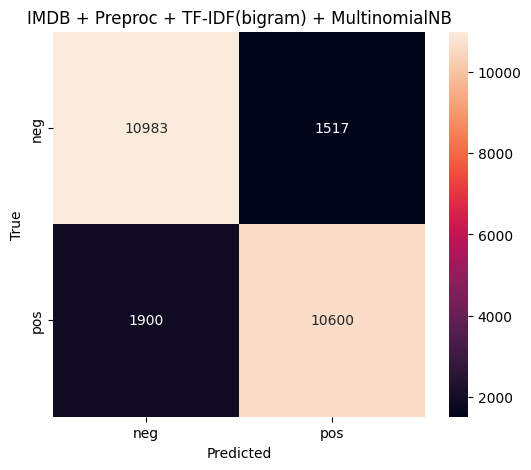


Interactive test. Type 'exit' to stop.
Введите отзыв (или 'exit'): This movie was absolutely fantastic! I loved it.
RAW TEXT:
This movie was absolutely fantastic! I loved it.

CLEANED TOKENS:
movie absolutely fantastic loved

PREDICTION: Positive
PROBS: Negative=0.323, Positive=0.677

TOP FEATURES (by TF-IDF in this text):
 - movie absolutely (tfidf=0.6787)
 - fantastic (tfidf=0.4554)
 - loved (tfidf=0.3997)
 - absolutely (tfidf=0.3896)
 - movie (tfidf=0.1432)

--------------------------------------------------

Введите отзыв (или 'exit'): Fantastic cast!
RAW TEXT:
Fantastic cast!

CLEANED TOKENS:
fantastic cast

PREDICTION: Positive
PROBS: Negative=0.198, Positive=0.802

TOP FEATURES (by TF-IDF in this text):
 - fantastic (tfidf=0.8323)
 - cast (tfidf=0.5543)

--------------------------------------------------

Введите отзыв (или 'exit'): This was a raunch. Tasteless waste of celluloid. How did such famous and talented actors agree to this?
RAW TEXT:
This was a raunch. Tasteless wast

In [ ]:

# Создаём TF-IDF и обучаем MultinomialNB. Параметры: max_features (максимальное количество слов - самые частые слова), min_df (минимальная частота встречаемости для попадания в словарь) — чтобы ограничить шум редких токенов
vectorizer_bi = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
Xtr_bi = vectorizer_bi.fit_transform(train_texts_clean)  # обучаем словарь
Xte_bi = vectorizer_bi.transform(test_texts_clean)        # применяем трансформацию к test

nb_bi = MultinomialNB()
nb_bi.fit(Xtr_bi, train_labels)

# Оценка качества
y_pred_bi = nb_bi.predict(Xte_bi)
acc_bi = accuracy_score(test_labels, y_pred_bi)
macro_f1_bi = f1_score(test_labels, y_pred_bi, average="macro")
print("Accuracy:", round(acc_bi, 4))
print("Macro-F1:", round(macro_f1_bi, 4))
print()
print(classification_report(test_labels, y_pred_bi, target_names=["neg","pos"]))

# confusion matrix: формат [[TN, FP],[FN, TP]]
cm_bi = confusion_matrix(test_labels, y_pred_bi)
tn_bi, fp_bi, fn_bi, tp_bi = cm_bi.ravel()
print(f"TN = {tn_bi}, TP = {tp_bi}, FN = {fn_bi}, FP = {fp_bi}")

# Визуализация матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm_bi, annot=True, fmt="d", xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("IMDB + Preproc + TF-IDF(bigram) + MultinomialNB")
plt.show()


# функция для проверки и отладки. Показывает, как текст чистится, какие признаки появляются в TF-IDF, а также предсказание и вероятности (predict_proba).

label_map = {0: "Negative", 1: "Positive"}

def predict_and_explain_bi(raw_text: str, top_feats: int = 10):
    cleaned = clean_text(raw_text)
    vec = vectorizer_bi.transform([cleaned])
    pred = nb_bi.predict(vec)[0]
    if hasattr(nb_bi, "predict_proba"):
        probs = nb_bi.predict_proba(vec)[0]
    else:
        probs = None

    print("RAW TEXT:")
    print(raw_text)
    print("\nCLEANED TOKENS:")
    print(cleaned)
    print("\nPREDICTION:", label_map[pred])

    if probs is not None:
        print("PROBS: Negative={:.3f}, Positive={:.3f}".format(probs[0], probs[1]))

    # top features (токены) с наибольшим TF-IDF для конкретного примера
    # превращаем в плотный массив, получаем индексы ненулевых колонок
    nz = vec.nonzero()[1]
    feat_names = np.array(vectorizer_bi.get_feature_names_out())
    if len(nz) > 0:
        # сортировка по значению TF-IDF в векторе
        values = vec.toarray()[0, nz]
        order = np.argsort(values)[::-1][:top_feats]
        top_idx = nz[order]
        print("\nTOP FEATURES (by TF-IDF in this text):")
        for i in top_idx:
            print(f" - {feat_names[i]} (tfidf={vec.toarray()[0,i]:.4f})")
    else:
        print("\nNo known features found in this text (rare tokens / all removed by stopwords).")

# цикл для ввода из консоли
print("\nInteractive test. Type 'exit' to stop.")
while True:
    s_bi = input("Введите отзыв (или 'exit'): ")
    if s_bi is None:
        break
    if s_bi.strip().lower() == "exit":
        break
    predict_and_explain_bi(s_bi)
    print("\n" + "-"*50 + "\n")


**Анализ результатов**

Точность результата улучшилась на 3 процента по причине замены униграм на биграммы. Это подтверждает гипотезу: биграммы лучше захватывают конструкции вроде "not so good" -> not_good. Ошибки распределились ровнее (recall по классам ближе друг к другу).

Нужно попробовать увеличить количество слов.

####**Модификация 3. Попытка использования словесных триграмм**

Accuracy: 0.8627
Macro-F1: 0.8627

              precision    recall  f1-score   support

         neg       0.85      0.87      0.86     12500
         pos       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

TN = 10936, TP = 10632, FN = 1868, FP = 1564


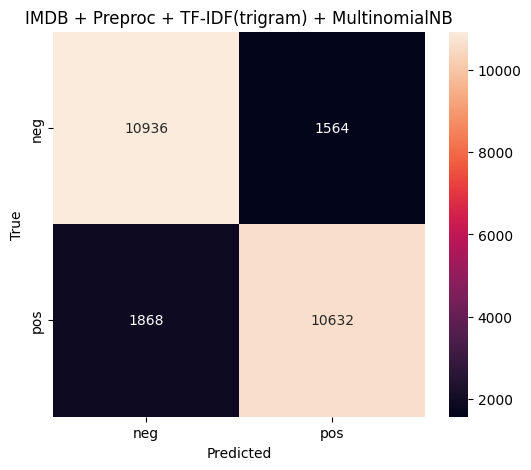


Interactive test. Type 'exit' to stop.
Введите отзыв (или 'exit'): exit


In [ ]:

# Создаём TF-IDF и обучаем MultinomialNB. Параметры: max_features (максимальное количество слов - самые частые слова), min_df (минимальная частота встречаемости для попадания в словарь) — чтобы ограничить шум редких токенов
vectorizer_tri = TfidfVectorizer(max_features=20000, ngram_range=(1,3), min_df=2)
Xtr_tri = vectorizer_tri.fit_transform(train_texts_clean)  # обучаем словарь
Xte_tri = vectorizer_tri.transform(test_texts_clean)        # применяем трансформацию к test

nb_tri = MultinomialNB()
nb_tri.fit(Xtr_tri, train_labels)

# Оценка качества
y_pred_tri = nb_tri.predict(Xte_tri)
acc_tri = accuracy_score(test_labels, y_pred_tri)
macro_f1_tri = f1_score(test_labels, y_pred_tri, average="macro")
print("Accuracy:", round(acc_tri, 4))
print("Macro-F1:", round(macro_f1_tri, 4))
print()
print(classification_report(test_labels, y_pred_tri, target_names=["neg","pos"]))

# confusion matrix: формат [[TN, FP],[FN, TP]]
cm_tri = confusion_matrix(test_labels, y_pred_tri)
tn_tri, fp_tri, fn_tri, tp_tri = cm_tri.ravel()
print(f"TN = {tn_tri}, TP = {tp_tri}, FN = {fn_tri}, FP = {fp_tri}")

# Визуализация матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm_tri, annot=True, fmt="d", xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("IMDB + Preproc + TF-IDF(trigram) + MultinomialNB")
plt.show()


# функция для проверки и отладки. Показывает, как текст чистится, какие признаки появляются в TF-IDF, а также предсказание и вероятности (predict_proba).

label_map = {0: "Negative", 1: "Positive"}

def predict_and_explain_tri(raw_text: str, top_feats: int = 10):
    cleaned = clean_text(raw_text)
    vec = vectorizer_tri.transform([cleaned])
    pred = nb_tri.predict(vec)[0]
    if hasattr(nb_tri, "predict_proba"):
        probs = nb_tri.predict_proba(vec)[0]
    else:
        probs = None

    print("RAW TEXT:")
    print(raw_text)
    print("\nCLEANED TOKENS:")
    print(cleaned)
    print("\nPREDICTION:", label_map[pred])

    if probs is not None:
        print("PROBS: Negative={:.3f}, Positive={:.3f}".format(probs[0], probs[1]))

    # top features (токены) с наибольшим TF-IDF для конкретного примера
    # превращаем в плотный массив, получаем индексы ненулевых колонок
    nz = vec.nonzero()[1]
    feat_names = np.array(vectorizer_tri.get_feature_names_out())
    if len(nz) > 0:
        # сортировка по значению TF-IDF в векторе
        values = vec.toarray()[0, nz]
        order = np.argsort(values)[::-1][:top_feats]
        top_idx = nz[order]
        print("\nTOP FEATURES (by TF-IDF in this text):")
        for i in top_idx:
            print(f" - {feat_names[i]} (tfidf={vec.toarray()[0,i]:.4f})")
    else:
        print("\nNo known features found in this text (rare tokens / all removed by stopwords).")

# цикл для ввода из консоли
print("\nInteractive test. Type 'exit' to stop.")
while True:
    s_tri = input("Введите отзыв (или 'exit'): ")
    if s_tri is None:
        break
    if s_tri.strip().lower() == "exit":
        break
    predict_and_explain_tri(s_tri)
    print("\n" + "-"*50 + "\n")


**Анализ результатов**

Триграммы не улучшили модель, скорее всего потому что они слишком специфичны и редки — модель переобучается на редкие фразы, вроде устойчивых выражений.

####**Модификация 4. Логарифмирование весов, фильтрация слишком частых слов, добавление учета буквенных n-грамм.**

**Улучшение TF-IDF признаков**

* Логарифмирование весов (sublinear_tf=True) уменьшает влияние очень частых слов).
* Фильтровать слишком частые слова (max_df=0.8), которые мало мало помогают.
* Комбинировать n-граммы как словесные так и буквенные Буквенные n-граммы (например, 3–5) помогают ловить растянутые слова (soooo good), опечатки (awesum вместо awesome) и сленг (looool, meh).


Accuracy: 0.8545
Macro-F1: 0.8544

              precision    recall  f1-score   support

         neg       0.84      0.88      0.86     12500
         pos       0.88      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



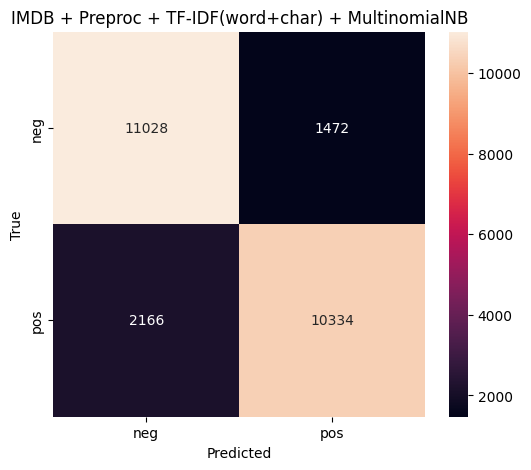

In [ ]:
# Word-level TF-IDF (униграммы + биграммы)
word_vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True
)

# Char-level TF-IDF (символьные n-граммы)
char_vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),   # три- до пентаграмм
    min_df=3,
    sublinear_tf=True
)

# Объединяем word + char признаки
vectorizer_union = FeatureUnion([
    ("word", word_vectorizer),
    ("char", char_vectorizer)
])

# Трансформация данных
Xtr_union = vectorizer_union.fit_transform(train_texts_clean)
Xte_union = vectorizer_union.transform(test_texts_clean)

# Наивный байес
nb_union = MultinomialNB()
nb_union.fit(Xtr_union, train_labels)

# Предсказания
y_pred_union = nb_union.predict(Xte_union)
acc_union = accuracy_score(test_labels, y_pred_union)
macro_f1_union = f1_score(test_labels, y_pred_union, average="macro")

print("Accuracy:", round(acc_union, 4))
print("Macro-F1:", round(macro_f1_union, 4))
print()
print(classification_report(test_labels, y_pred_union, target_names=["neg","pos"]))

cm_union = confusion_matrix(test_labels, y_pred_union)
plt.figure(figsize=(6,5))
sns.heatmap(cm_union, annot=True, fmt="d", xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("IMDB + Preproc + TF-IDF(word+char) + MultinomialNB")
plt.show()


Результат ухудшился на процент. Вероятно легкое переобучение. Делаем вывод, что наивный байес сюда действительно мало подходит, это довольно грубая векторизация, и есть смысл попробовать ее усилить, например, с помощью логистисечкой регрессии.

###**Модель 2. TF‑IDF + LogisticRegression**

Содержит:
* TF‑IDF с ограничением фич 20000 + LogisticRegression.
* Метрики: accuracy, F1, отчёт, confusion matrix.
* Простой интерактив для ручной проверки.

####**Модификация 5. Замена классификатора.**

Accuracy: 0.8916
Macro-F1: 0.8916

              precision    recall  f1-score   support

         neg       0.89      0.89      0.89     12500
         pos       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

TN = 11183, TP = 11107, FN = 1393, FP = 1317


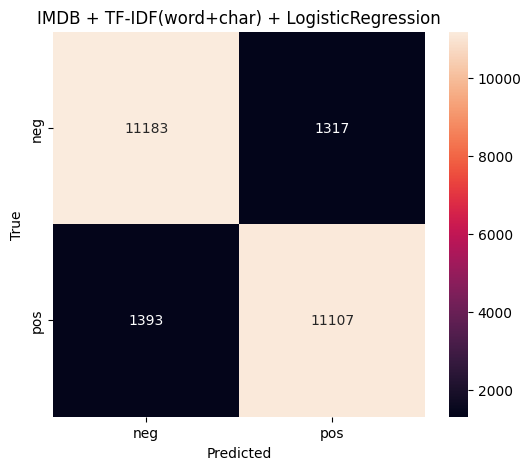


Interactive test. Type 'exit' to stop.
Введите отзыв (или 'exit'): soo goood!!
RAW TEXT:
soo goood!!

CLEANED TOKENS:
soo goood

PREDICTION: Positive
PROBS: Negative=0.401, Positive=0.599

TOP FEATURES (by TF-IDF in this text):
 - word__soo (tfidf=1.0000)
 - char__ gooo (tfidf=0.3764)
 - char__oood (tfidf=0.3656)
 - char__soo g (tfidf=0.3656)
 - char__gooo (tfidf=0.3656)
 - char__soo  (tfidf=0.3034)
 - char__oo go (tfidf=0.3034)
 - char__oo g (tfidf=0.2672)
 - char__ooo (tfidf=0.2195)
 - char__o goo (tfidf=0.1965)

--------------------------------------------------

Введите отзыв (или 'exit'): awsooome!
RAW TEXT:
awsooome!

CLEANED TOKENS:
awsooome

PREDICTION: Negative
PROBS: Negative=0.527, Positive=0.473

TOP FEATURES (by TF-IDF in this text):
 - char__ooom (tfidf=0.5015)
 - char__sooo (tfidf=0.3541)
 - char__awso (tfidf=0.3458)
 - char__wso (tfidf=0.3416)
 - char__aws (tfidf=0.3213)
 - char__oome (tfidf=0.3199)
 - char__ooo (tfidf=0.3082)
 - char__soo (tfidf=0.2096)
 - char__oom (

In [29]:
word_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
char_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2)

vectorizer_wc = FeatureUnion([
    ("word", word_vectorizer),
    ("char", char_vectorizer)
])

# Обучаем словарь
Xtr_wc = vectorizer_wc.fit_transform(train_texts_clean)
Xte_wc = vectorizer_wc.transform(test_texts_clean)

# классификатор (лин регр)
lr_wc = LogisticRegression(max_iter=200, solver="liblinear")
lr_wc.fit(Xtr_wc, train_labels)

# предскаание
y_pred_wc = lr_wc.predict(Xte_wc)
acc_wc = accuracy_score(test_labels, y_pred_wc)
macro_f1_wc = f1_score(test_labels, y_pred_wc, average="macro")

print("Accuracy:", round(acc_wc, 4))
print("Macro-F1:", round(macro_f1_wc, 4))
print()
print(classification_report(test_labels, y_pred_wc, target_names=["neg","pos"]))
cm_wc = confusion_matrix(test_labels, y_pred_wc)
tn_wc, fp_wc, fn_wc, tp_wc = cm_wc.ravel()
print(f"TN = {tn_wc}, TP = {tp_wc}, FN = {fn_wc}, FP = {fp_wc}")

plt.figure(figsize=(6,5))
sns.heatmap(cm_wc, annot=True, fmt="d", xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("IMDB + TF-IDF(word+char) + LogisticRegression")
plt.show()

label_map = {0: "Negative", 1: "Positive"}

def predict_and_explain_wc(raw_text: str, top_feats: int = 10):
    cleaned = clean_text(raw_text)
    vec = vectorizer_wc.transform([cleaned])
    pred = lr_wc.predict(vec)[0]

    if hasattr(lr_wc, "predict_proba"):
        probs = lr_wc.predict_proba(vec)[0]
    else:
        probs = None

    print("RAW TEXT:")
    print(raw_text)
    print("\nCLEANED TOKENS:")
    print(cleaned)
    print("\nPREDICTION:", label_map[pred])

    if probs is not None:
        print("PROBS: Negative={:.3f}, Positive={:.3f}".format(probs[0], probs[1]))

    # top features (по TF-IDF для данного текста)
    nz = vec.nonzero()[1]
    feat_names = np.array(vectorizer_wc.get_feature_names_out())
    if len(nz) > 0:
        values = vec.toarray()[0, nz]
        order = np.argsort(values)[::-1][:top_feats]
        top_idx = nz[order]
        print("\nTOP FEATURES (by TF-IDF in this text):")
        for i in top_idx:
            print(f" - {feat_names[i]} (tfidf={vec.toarray()[0,i]:.4f})")
    else:
        print("\nNo known features found in this text (rare tokens / all removed).")

# цикл для консоли
print("\nInteractive test. Type 'exit' to stop.")
while True:
    s_wc = input("Введите отзыв (или 'exit'): ")
    if s_wc is None:
        break
    if s_wc.strip().lower() == "exit":
        break
    predict_and_explain_wc(s_wc)
    print("\n" + "-"*50 + "\n")


**Анализ результатов**

1. Получен значительный прирост точности модели, просто за счет смены векторизации. Логистическая регрессия оказалась лучше, чем наивный Байес, она что умеет давать веса, отражающие силу корреляции признаков, а не только вероятность.

2. Классы почти симметричны. Precision/Recall/F1 по `pos` и `neg` почти одинаковые (0.89). Это говорит, что модель умеет одинаково хорошо ловить положительные и отрицательные отзывы.

3. Char-level TF-IDF (3–5 символов) помогло: модель теперь улавливает эмоциональную окраску слов с опечатками и "растягиванием" (например, *goooood*, *baaad*, *awesooome*).